In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [18]:
data = pd.read_csv("day.csv", index_col=0)
data = data[['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']]
train, test = train_test_split(data, test_size=0.2)
train

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
instant,,,,,,,,,,,
202,3,7,0,4,1,2,0.815000,0.826371,0.691250,0.222021,3784
665,4,10,0,5,1,2,0.545833,0.522750,0.807083,0.132467,7444
165,2,6,0,2,1,1,0.604167,0.591546,0.507083,0.269283,4891
704,4,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,6606
487,2,5,0,2,1,2,0.613333,0.577021,0.659583,0.156096,5740
...,...,...,...,...,...,...,...,...,...,...,...
270,4,9,0,2,1,2,0.636667,0.574525,0.885417,0.118171,4120
385,1,1,0,5,1,2,0.217500,0.220958,0.450000,0.202750,3163
549,3,7,0,1,1,1,0.781667,0.702038,0.447083,0.195267,6227


In [19]:
categorial_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday']
real_features = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed']
target_feature = 'cnt'

Посмотрим на зависимость atemp от temp

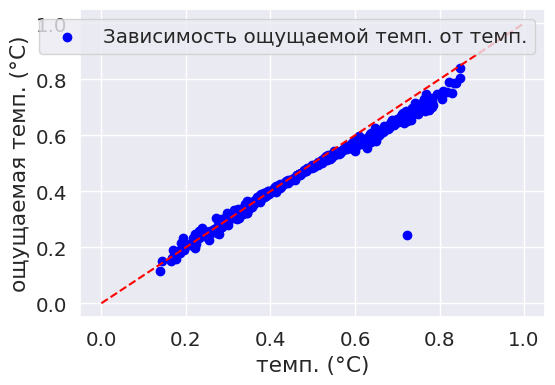

In [61]:
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.scatter(train['temp'], train['atemp'], color='blue', label='Зависимость ощущаемой темп. от темп.')
plt.xlabel('темп. (°C)')
plt.ylabel('ощущаемая темп. (°C)')
plt.legend()
plt.grid(True)

x = np.linspace(0, 1, 1000)
plt.plot(x, x, color='red', linestyle='--', label='y=x')

plt.show()

Видна явная линейная зависимость, поэтому при анализе графиков будем рассматривать только реальную температуру

In [21]:
new_real_features = ['weathersit', 'temp', 'hum', 'windspeed']

Оценим связь между признаками

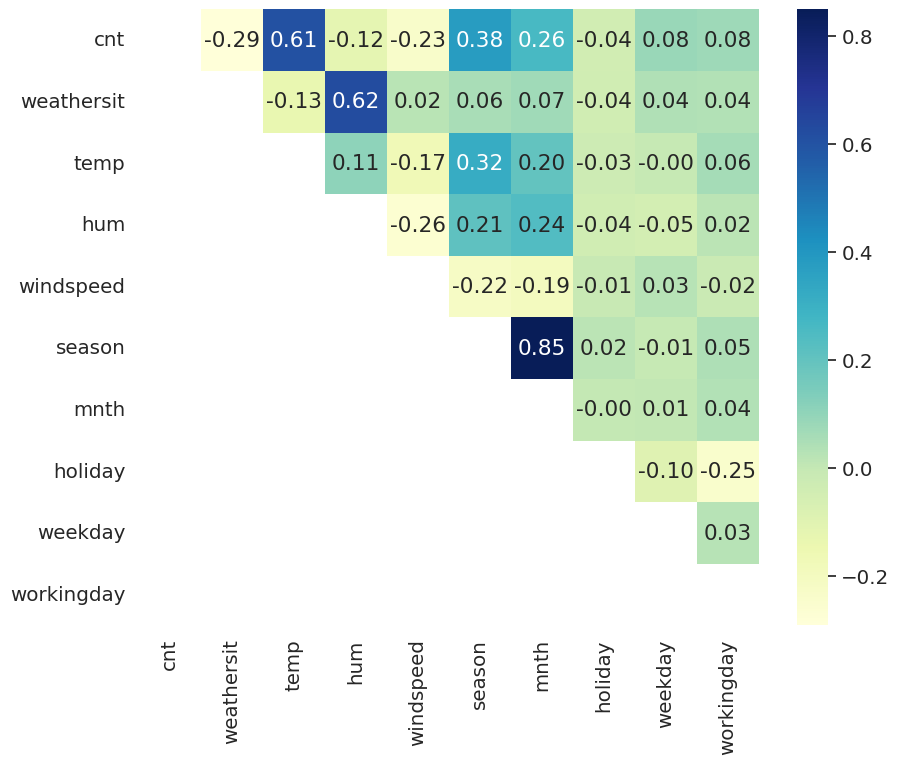

In [22]:
plt.subplots(figsize=(10, 8))
mask = np.tril(np.ones_like(train[['cnt'] + new_real_features + categorial_features].corr(), dtype=bool))
sns.heatmap(train[['cnt'] + new_real_features + categorial_features].corr(numeric_only=True), cmap="YlGnBu", annot=True, fmt=".2f", mask=mask)
plt.show()

Видна сильная связь между сезонами и месяцами (что очевидно), проверим, как другие признаки зависят от этих параметров

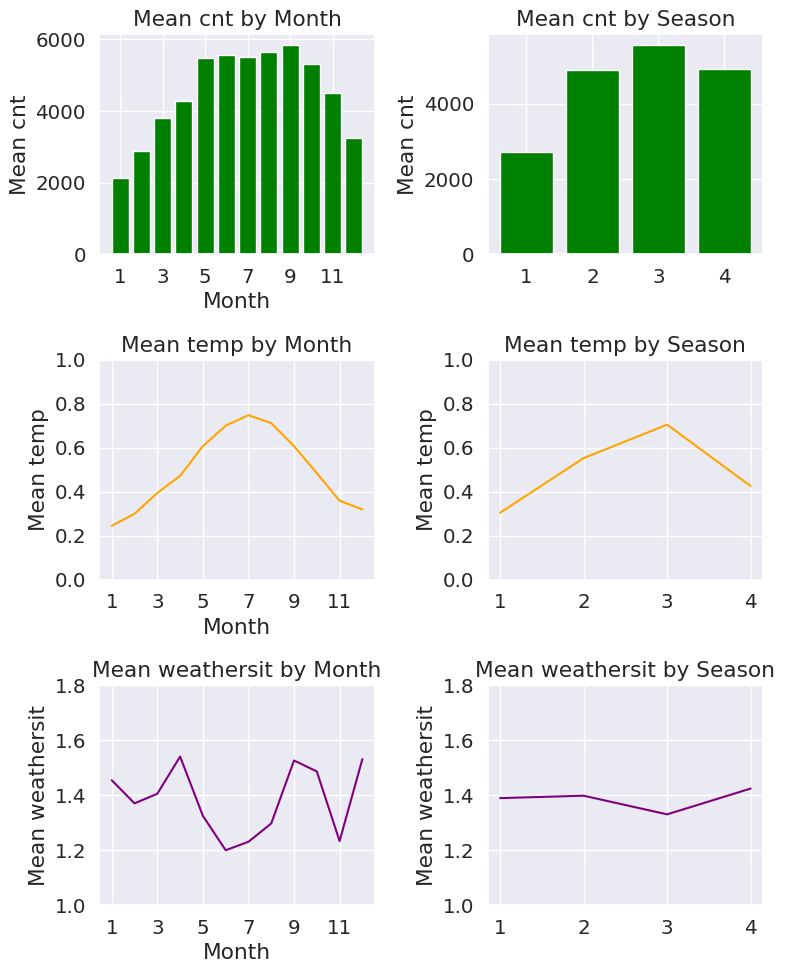

In [64]:
train_grouped_month = train.groupby('mnth').agg({'weathersit': 'mean', 'temp': 'mean', 'cnt': 'mean'})
train_grouped_season = train.groupby('season').agg({'weathersit': 'mean', 'temp': 'mean', 'cnt': 'mean'})

fig, axes = plt.subplots(3, 2, figsize=(8, 10))  # 3 rows, 2 columns

axes[0, 0].bar(train_grouped_month.index, train_grouped_month['cnt'], color = 'green')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Mean cnt')
axes[0, 0].set_title('Mean cnt by Month')

axes[1, 0].plot(train_grouped_month.index, train_grouped_month['temp'], color='orange')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean temp')
axes[1, 0].set_title('Mean temp by Month')
axes[1, 0].set_ylim(0, 1)

axes[2, 0].plot(train_grouped_month.index, train_grouped_month['weathersit'], color='purple')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('Mean weathersit')
axes[2, 0].set_title('Mean weathersit by Month')
axes[2, 0].set_ylim(1, 1.8)

axes[0, 1].bar(train_grouped_season.index, train_grouped_season['cnt'], color='green')
axes[0, 1].set_ylabel('Mean cnt')
axes[0, 1].set_title('Mean cnt by Season')

axes[1, 1].plot(train_grouped_season.index, train_grouped_season['temp'], color='orange')
axes[1, 1].set_ylabel('Mean temp')
axes[1, 1].set_title('Mean temp by Season')
axes[1, 1].set_ylim(0, 1)

axes[2, 1].plot(train_grouped_season.index, train_grouped_season['weathersit'], color='purple')
axes[2, 1].set_ylabel('Mean weathersit')
axes[2, 1].set_title('Mean weathersit by Season')
axes[2, 1].set_ylim(1, 1.8)

for i in range(3):
    axes[i, 0].set_xticks(train_grouped_month.index[::2])
    axes[i, 1].set_xticks(train_grouped_season.index)

plt.tight_layout()

plt.show()

Количество использованных велосипедов увеличивается к лету, как и температура, погода же летом в среднем более благоприятная

Теперь разделим данные по сезонам и рабочим/нерабочим дням и построим парные графики для выявления выбросов

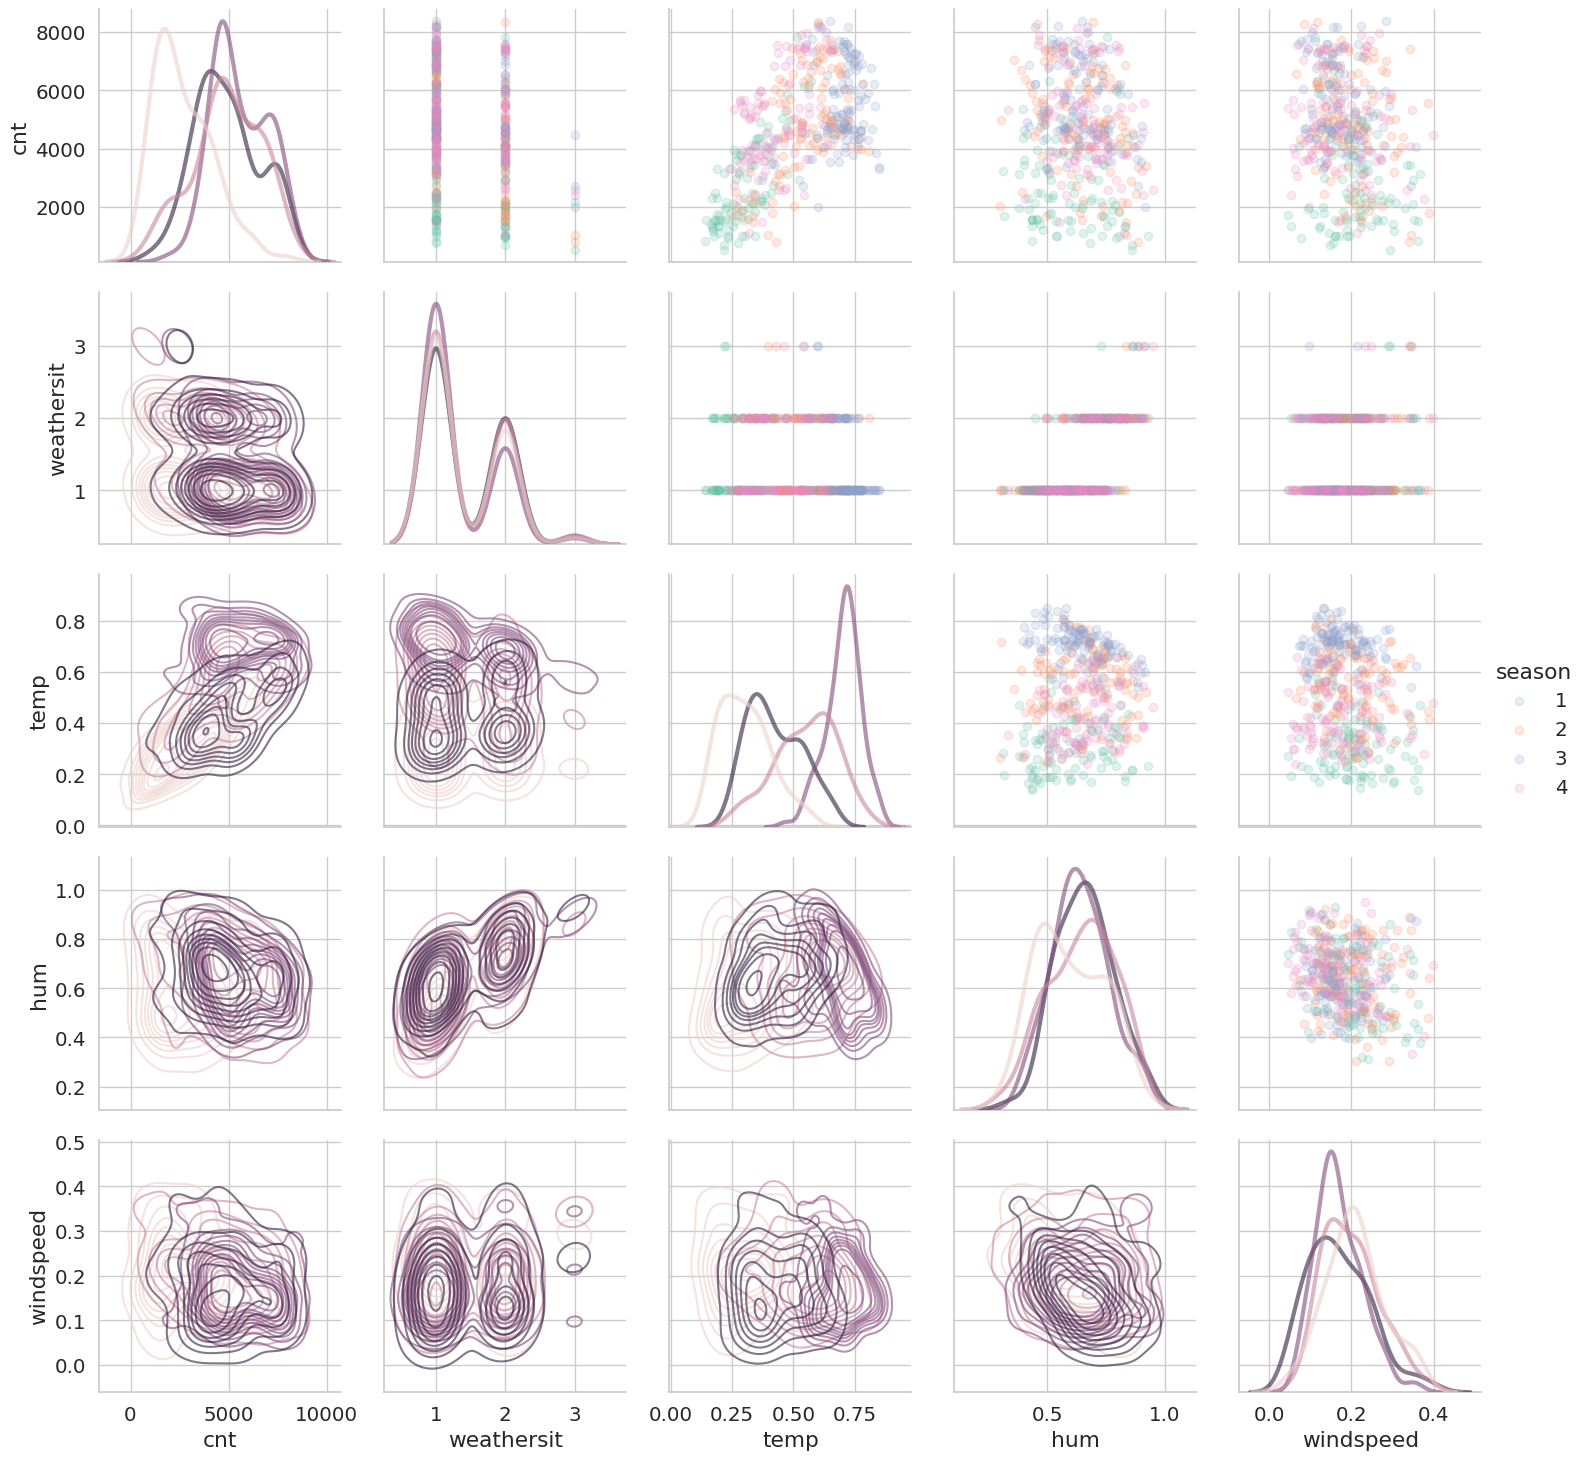

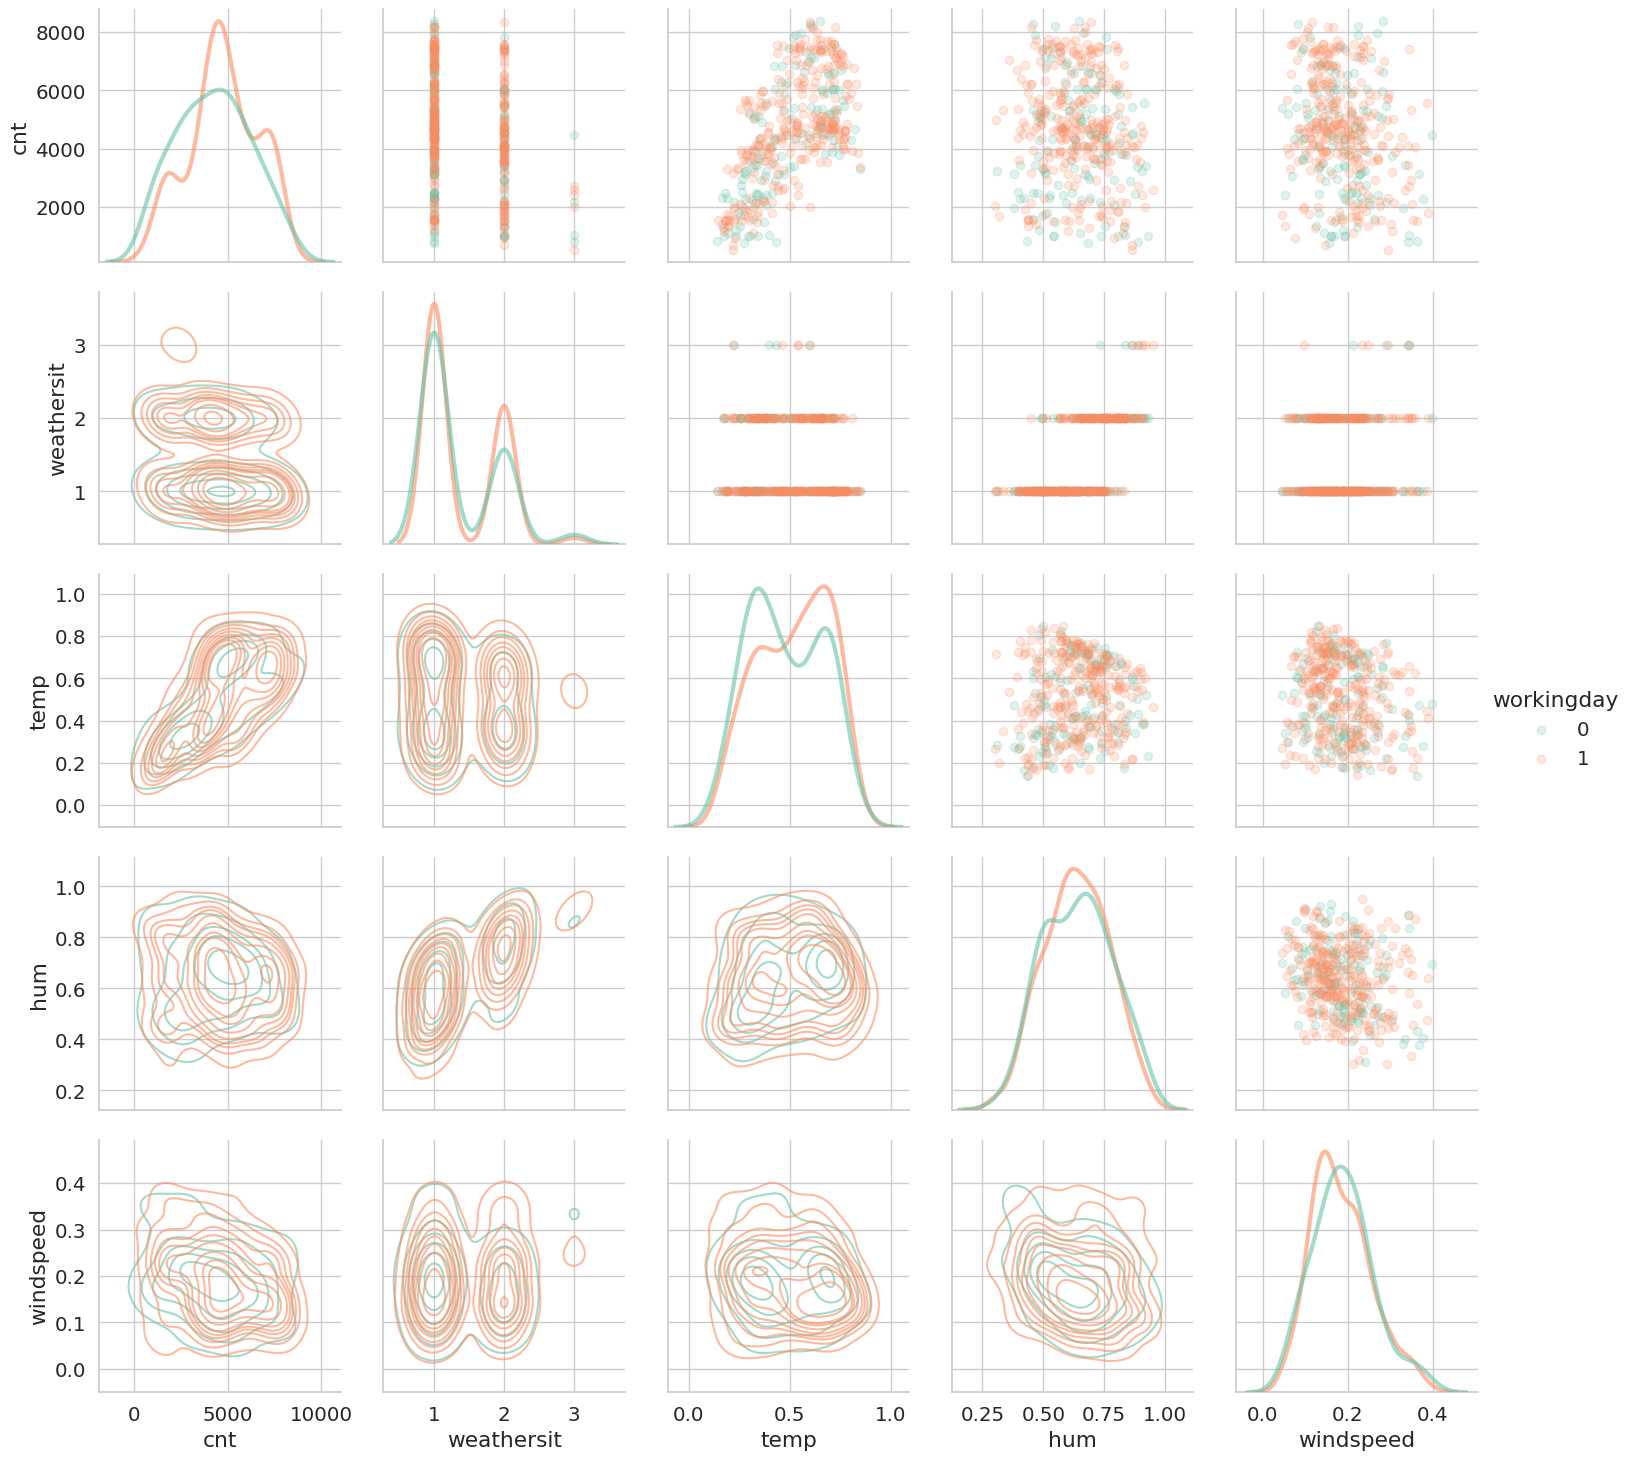

In [67]:
sns.set_style("whitegrid")

for hue in ['season', 'workingday']:
    g = sns.PairGrid(train[[target_feature] + new_real_features + [hue]], 
                     hue=hue, diag_sharey=False, height=3)
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.2)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, 
               common_norm=False)
    
    g.add_legend()

Попробуем выявить зависимость целевого признака от температуры. Усредним количество велосипедов за день для разных интервалов температур

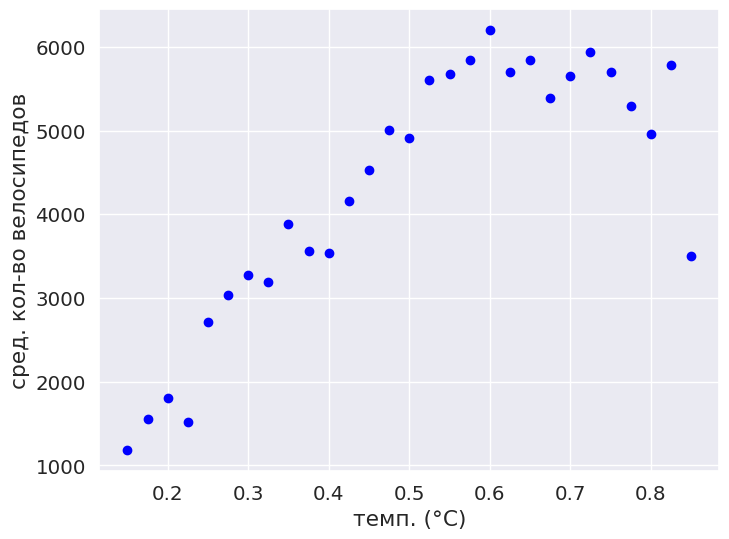

In [68]:
sns.set_style("darkgrid")

rounded_temp_train = train.rename(columns={"temp": "rounded_temp"})
rounded_temp_train['rounded_temp'] = np.round(rounded_temp_train['rounded_temp']*40, decimals=0)/40
grouped_rounded_temp = rounded_temp_train.groupby('rounded_temp').agg({'cnt': 'mean'})

plt.figure(figsize=(8, 6))
plt.scatter(grouped_rounded_temp.index, grouped_rounded_temp['cnt'], color='blue')
plt.xlabel('темп. (°C)')
plt.ylabel('сред. кол-во велосипедов')
plt.grid(True)

plt.show()

Видна чётко определившаяся связь, в первой половине диапазона похожая на линейную. Можем предположить, что это квадратичная зависимость с ветками вниз, имеющая вершину в точке (0.7, 0.9*6000)

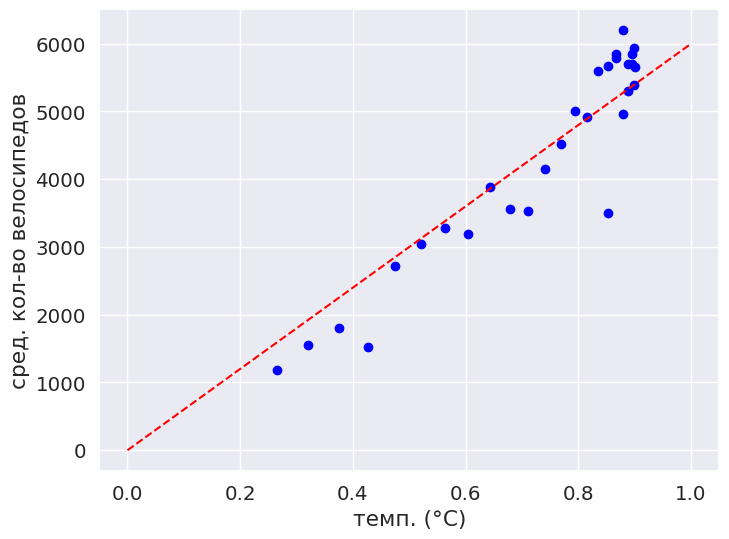

In [69]:
corr_cnt = grouped_rounded_temp['cnt']
corr_temp = -2.1*(grouped_rounded_temp.index - 0.7)**2 + 0.9

plt.figure(figsize=(8, 6))
plt.scatter(corr_temp, corr_cnt, color='blue')
plt.xlabel('темп. (°C)')
plt.ylabel('сред. кол-во велосипедов')
plt.grid(True)

x = np.linspace(0, 1, 1000)
plt.plot(x, 6000*x, color='red', linestyle='--', label='y=x')

plt.show()

Оценим корреляцию целевого признака и температуры

In [28]:
corr_cnt = train[['temp', 'cnt']].copy()
corr_cnt.corr()

,temp,cnt
temp,1.00000,0.60798
cnt,0.60798,1.00000


Теперь оценим корреляцию целевого признака и подобранной функции от температуры

In [29]:
corr_cnt.insert(1, "func_temp", -(train['temp'] - 0.7)**2, True)
corr_cnt.drop(columns='temp', inplace = True)
corr_cnt.corr()

,func_temp,cnt
func_temp,1.000000,0.658861
cnt,0.658861,1.000000


Как мы видим, корреляция увеличилась, но не сильно

Теперь посмотрим на зависимость целевого признака от влажности. Аналогично сгруппируем данные по интервалам влажности и посчитаем среднее cnt для них

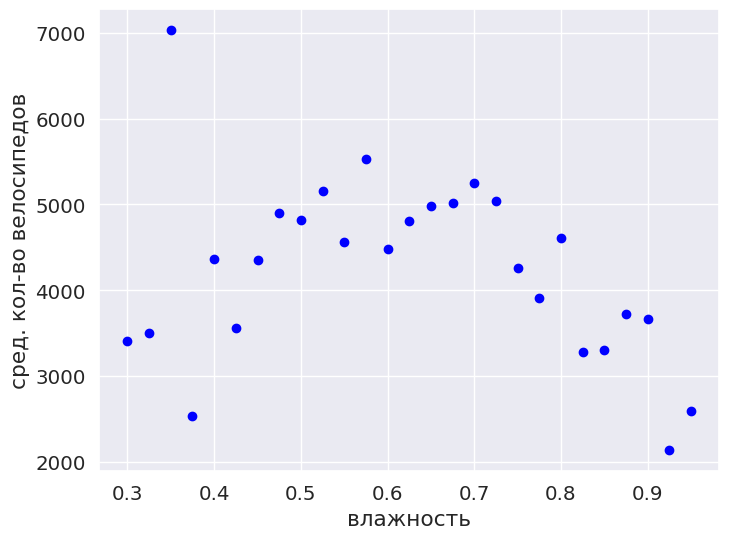

In [70]:
rounded_hum_train = train.rename(columns={"hum": "rounded_hum"})
rounded_hum_train['rounded_hum'] = np.round(rounded_hum_train['rounded_hum']*40, decimals=0)/40
grouped_rounded_hum = rounded_hum_train.groupby('rounded_hum').agg({'cnt': 'mean'})

plt.figure(figsize=(8, 6))
plt.scatter(grouped_rounded_hum.index, grouped_rounded_hum['cnt'], color='blue')
plt.xlabel('влажность')
plt.ylabel('сред. кол-во велосипедов')
plt.grid(True)

plt.show()

При влажности больше 0.5 хорошо проглядывается убывающая зависимость. Попробуем снова подобрать функцию

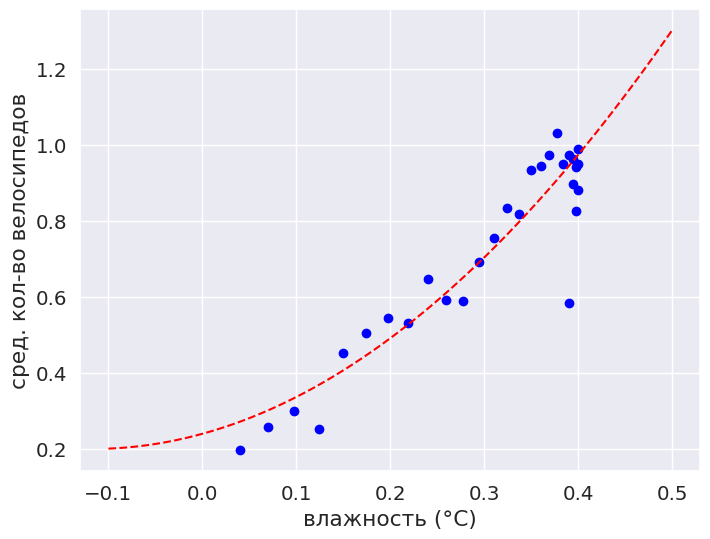

In [71]:
corrected_cnt_hum = grouped_rounded_temp['cnt']/6000
corrected_hum = -(grouped_rounded_temp.index - 0.75)**2 + 0.4

plt.figure(figsize=(8, 6))
plt.scatter(corrected_hum, corrected_cnt_hum, color='blue')
plt.xlabel('влажность (°C)')
plt.ylabel('сред. кол-во велосипедов')
plt.grid(True)

x = np.linspace(-0.1, 0.5, 1000)
plt.plot(x, (1.7*x + 0.2)**2 + 0.2, color='red', linestyle='--', label='y=x')

plt.show()

In [32]:
another_corrected_hum = (1.7*corrected_hum + 0.2)**2 + 0.2
corrected_cnt_hum = pd.DataFrame(corrected_cnt_hum)
another_corrected_hum = pd.DataFrame(another_corrected_hum)
corrected_cnt_hum = corrected_cnt_hum.reset_index().drop(columns='rounded_temp')
corrected_cnt_hum['rounded_temp'] = another_corrected_hum
corr_cnt.corr()

,func_temp,cnt
func_temp,1.000000,0.658861
cnt,0.658861,1.000000


Снова есть неплохая корреляция, но, возможно, это существует только на тренировочных данных

**Выводы по графикам:**

Данные достаточно плотно сгруппированы, явных выбросов почти нет, можно убрать их простыми условиями на некоторые числовые параметры

Есть несколько сильно зависимых между собой признаков: temp и atemp зависят линейно, mnth и season связаны своей природой, поэтому можно оставлять только один признак из каждой пары

Хорошо проглядывается зависимость целевого признака от температуры и влажности. Из категориальных признаков стоит выделить явную зависимость количества велосипедов от weathersit. Так как месяц и сезон напрямую связаны с погодой, целевой признак зависит и от них. Визуальным анализом связь с выходными и праздниками не проглядывается

Можно попробовать рассмотреть квадратичную зависимость от температуры, смещённую в самое благоприятное значение

**Процедура предобработки данных:**

**a).** убираем выбросы

**б).** обучаем кодировщик и кодируем категориальные признаки

**в).** можно стандартизировать вещественные признаки, но на этом этапе этого не требуется

In [33]:
starting_len = len(train)

train = train[(train['windspeed'] < 0.4) &
              (train['windspeed'] > 0.03) &
              (train['temp'] < 0.85) &
              (train['temp'] > 0.1) &
              (train['hum'] < 0.95) &
              (train['hum'] > 0.3) &
              (train['cnt'] < 8500) &
              (train['cnt'] > 500)]

print('Изначально записей: ', starting_len)
print('Удалили: ', np.round((1 - len(train)/starting_len)*100, decimals=1), '% записей')
print('После удаления выбросов записей осталось: ', len(train))

Изначально записей:  584
Удалили:  3.1 % записей
После удаления выбросов записей осталось:  566


In [34]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
train_cat = encoder.fit_transform(train[categorial_features])
X_train = np.hstack([train[real_features], train_cat])

#### 3. Обучение модели и ее анализ

In [35]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, train[target_feature]) 
model.coef_, \
model.intercept_

(array([-3.77809964e+02,  6.33276177e+03,  1.96473177e+02, -3.28047915e+03,
        -3.96779932e+03,  9.26475258e+02,  7.42711846e+02,  1.53987294e+03,
         8.76270456e+00,  2.03229574e+02, -9.13631375e+01,  1.30872024e+02,
        -5.63767714e+02, -1.05192779e+03, -4.47834542e+02,  3.96454599e+02,
         1.96550504e+02, -4.02115272e+02, -1.57184787e+02, -2.40668791e+02,
        -5.42158777e+01, -9.01038234e+01,  1.15246888e+00,  5.51730833e+01,
         1.45350808e+02,  4.46871905e+02,  2.98025451e+02]),
 3727.7198583832596)

In [36]:
starting_len_test = len(test)

test = test[(test['windspeed'] < 0.4) &
              (test['windspeed'] > 0.03) &
              (test['temp'] < 0.85) &
              (test['temp'] > 0.1) &
              (test['hum'] < 0.95) &
              (test['hum'] > 0.3) &
              (test['cnt'] < 8500) &
              (test['cnt'] > 500)]

print('Изначально записей: ', starting_len_test)
print('Удалили: ', np.round((1 - len(test)/starting_len_test)*100, decimals=1), '% записей')
print('После удаления выбросов записей осталось: ', len(test))

Изначально записей:  147
Удалили:  5.4 % записей
После удаления выбросов записей осталось:  139


In [37]:
test_cat = encoder.transform(test[categorial_features])

X_test = np.hstack([test[real_features], test_cat])

test_preds = model.predict(X_test)

metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5, \
metrics.mean_absolute_error(test[target_feature], test_preds)

(1198.0820328845016, 1055.865017338171)

In [38]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [39]:
mean_absolute_percentage_error(test[target_feature], test_preds)

32.06351152890804

In [40]:
X_with_1 = X_train.copy()
ones_column = np.ones((len(X_with_1), 1))
X_with_1 = np.hstack((ones_column, X_with_1))

np.linalg.inv(X_with_1.T.dot(X_with_1)).dot(X_with_1.T).dot(train[target_feature])

array([  -2553.1085963 ,    -498.23713086, -292121.67797112,
        303758.39651914,   -3589.47176465,   15170.22196634,
          1800.63899367,    5197.08395589,    2272.87850418,
          1128.23937608,    2772.006859  ,    3099.3298742 ,
          8194.66767185,   11185.83854517,    9950.69952907,
         12868.89789107,    8044.62400229,    4018.38309009,
          1373.96510447,    1379.94775316,    4198.81292362,
          1176.20302822,     854.96464727,    1271.80518999,
          -691.91002847,    3040.63097572,     446.87190517,
         -2094.44182205])

In [41]:
prev_train = train.copy()
prev_test = test.copy()
prev_categorial_features = categorial_features
prev_real_features = real_features

In [42]:
train = train.drop(columns=['atemp', 'season'])
categorial_features = ['mnth', 'holiday', 'weekday', 'workingday']
real_features = ['weathersit', 'temp', 'hum', 'windspeed']

In [43]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
train_cat = encoder.fit_transform(train[categorial_features])

X_train = np.hstack([train[real_features], train_cat])

X_with_1 = X_train.copy()
ones_column = np.ones((len(X_with_1), 1))
X_with_1 = np.hstack((ones_column, X_with_1))

formula_coef = np.linalg.inv(X_with_1.T.dot(X_with_1)).dot(X_with_1.T).dot(train[target_feature])

formula_coef

array([  -575.96089196,   -409.09260431,   5940.46773548,  -2883.44749448,
        -4161.97970584,    -53.36974267,    236.09258937,    586.54107442,
          707.78320908,     73.00606781,   -517.88677029,   -124.44016367,
         1270.93395356,   1549.37905573,    875.82070581,   1063.76110881,
         8724.13336904, -10491.1811893 ,  -5867.63414734,   -705.55243513,
        -4657.15545569,  -3896.43030254,    460.56509209,   6300.16609852])

In [44]:
test_cat = encoder.transform(test[categorial_features])

X_test = np.hstack([test[real_features], test_cat])

ones_column = np.ones((len(X_test), 1))
X_test_with_1 = np.hstack((ones_column, X_test))

formula_preds = X_test_with_1.dot(formula_coef)

metrics.mean_squared_error(test[target_feature], formula_preds) ** 0.5, \
metrics.mean_absolute_error(test[target_feature], formula_preds), \
mean_absolute_percentage_error(test[target_feature], formula_preds)

(4674.346269758686, 4022.8159218333685, 117.22201196042322)

**Выводы:** при линейно зависимых признаках матрица получается вырожденной или с очень большими коэффициентами, при удалении зависимых столбцов коэффициенты становятся меньше

---
### Задача 2.

В данной задаче мы продолжим анализировать данные велопроката из задачи 2, используя указанные в ней признаки.

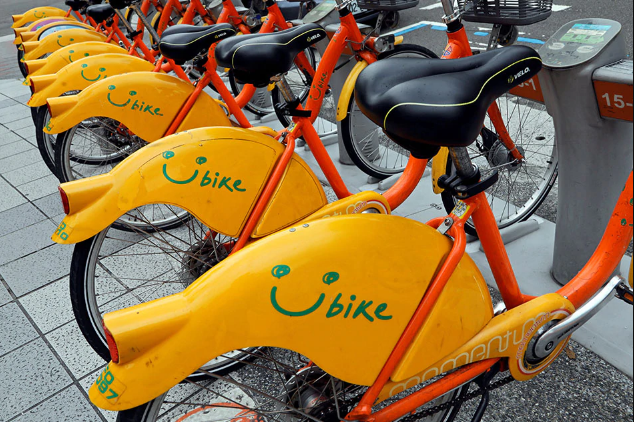

Для начала реализуtv класс для работы с моделью ridge-регрессии, используя явную формулу из предыдущей задачи. Интерфейс этого класса соответствует стандарту библиотеки `sklearn`, который использует также множество других библиотек.

In [180]:
class RidgeRegression:
    def __init__(self, lambd=0.1, fit_intercept=True):
        '''
        Инициализация модели.
        
        Аргументы:
        lambd -- параметр регуляризации.
        fit_intercept -- добавить ли константный признак.
        '''
        
        self.lambd = lambd
        self.fit_intercept = fit_intercept
        
    def fit(self, X, Y):
        '''
        Обучение модели ridge-регрессии.
        
        Аргументы:
        X -- numpy-матрица объект-признак размера (n, d);
        Y -- numpy-вектор значений целевого признака размера (n,).
        '''
        
        # Посчитайте оценки коэффициентов и, возможно, 
        # еще что-то, что пригодится в predict.
        X_copy = X.copy()
        Y_copy = Y.copy()
        
        if self.fit_intercept:
            ones_column = np.ones((len(X_copy), 1))
            X_copy = np.hstack((ones_column, X_copy))
        
        self.all_coef = np.linalg.inv(X_copy.T.dot(X_copy) + np.identity(X_copy.shape[1])*self.lambd).dot(X_copy.T).dot(Y_copy)
        self.coef = self.all_coef[1:]
        self.intercept = self.all_coef[0]
        
        return self
    
    
    def predict(self, X):
        '''
        Вычисление предсказаний.
        
        Аргументы:
        X -- numpy-матрица объект-признак размера (n, d);
        
        Возвращает:
        predictions -- предсказания в виде numpy-вектора размера (n,).
        '''
        
        # Посчитайте предсказания
        X_copy = X.copy()
        
        if self.fit_intercept:
            ones_column = np.ones((len(X_copy), 1))
            X_copy = np.hstack((ones_column, X_copy))
            
        predictions = X_copy.dot(self.all_coef)
        
        return predictions

In [181]:
train_validate_data, test = train_test_split(data, test_size=0.2)
train, validate = train_test_split(train_validate_data, test_size=0.25)

categorial_features = ['mnth', 'holiday', 'weekday', 'workingday']
real_features = ['weathersit', 'temp', 'hum', 'windspeed']
target_feature = 'cnt'

In [182]:
starting_len = len(train)

train = train[(train['windspeed'] < 0.4) &
              (train['windspeed'] > 0.03) &
              (train['temp'] < 0.85) &
              (train['temp'] > 0.1) &
              (train['hum'] < 0.95) &
              (train['hum'] > 0.3) &
              (train['cnt'] < 8500) &
              (train['cnt'] > 500)]

print('Изначально записей: ', starting_len)
print('Удалили: ', np.round((1 - len(train)/starting_len)*100, decimals=1), '% записей')
print('После удаления выбросов записей осталось: ', len(train))

Изначально записей:  438
Удалили:  3.2 % записей
После удаления выбросов записей осталось:  424


In [183]:
starting_len = len(validate)

validate = validate[(validate['windspeed'] < 0.4) &
              (validate['windspeed'] > 0.03) &
              (validate['temp'] < 0.85) &
              (validate['temp'] > 0.1) &
              (validate['hum'] < 0.95) &
              (validate['hum'] > 0.3) &
              (validate['cnt'] < 8500) &
              (validate['cnt'] > 500)]

print('Изначально записей: ', starting_len)
print('Удалили: ', np.round((1 - len(validate)/starting_len)*100, decimals=1), '% записей')
print('После удаления выбросов записей осталось: ', len(validate))

Изначально записей:  146
Удалили:  3.4 % записей
После удаления выбросов записей осталось:  141


In [184]:
starting_len = len(test)

test = test[(test['windspeed'] < 0.4) &
              (test['windspeed'] > 0.03) &
              (test['temp'] < 0.85) &
              (test['temp'] > 0.1) &
              (test['hum'] < 0.95) &
              (test['hum'] > 0.3) &
              (test['cnt'] < 8500) &
              (test['cnt'] > 500)]

print('Изначально записей: ', starting_len)
print('Удалили: ', np.round((1 - len(test)/starting_len)*100, decimals=1), '% записей')
print('После удаления выбросов записей осталось: ', len(test))

Изначально записей:  147
Удалили:  4.8 % записей
После удаления выбросов записей осталось:  140


In [185]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
scaler = StandardScaler()

train_cat = encoder.fit_transform(train[categorial_features])
train_real = scaler.fit_transform(train[real_features])
X_train = np.hstack([train_real, train_cat])

validate_cat = encoder.transform(validate[categorial_features])
validate_real = scaler.transform(validate[real_features])
X_validate = np.hstack([validate_real, validate_cat])

test_cat = encoder.transform(test[categorial_features])
test_real = scaler.transform(test[real_features])
X_test = np.hstack([test_real, test_cat])

Определим сетку значений гиперпараметра $\lambda$ и обучим для каждого значения сетки модель ridge-регрессии

In [186]:
k = 100
lambd_array = np.logspace(-1, 6, k)

rmse_validate = np.zeros(k)
mae_validate = np.zeros(k)
mape_validate = np.zeros(k)

rmse_train = np.zeros(k)
mae_train = np.zeros(k)
mape_train = np.zeros(k)

model_coefficients = []

ind = 0
for lambd in lambd_array:
    model = RidgeRegression(lambd, fit_intercept=True)
    model.fit(X_train, train[target_feature])

    train_preds = model.predict(X_train)
    np.put(mae_train, ind, metrics.mean_absolute_error(train[target_feature], train_preds))
    np.put(rmse_train, ind, metrics.mean_squared_error(train[target_feature], train_preds) ** 0.5)
    np.put(mape_train, ind, mean_absolute_percentage_error(train[target_feature], train_preds))

    validate_preds = model.predict(X_validate)
    np.put(mae_validate, ind, metrics.mean_absolute_error(validate[target_feature], validate_preds))
    np.put(rmse_validate, ind, metrics.mean_squared_error(validate[target_feature], validate_preds) ** 0.5)
    np.put(mape_validate, ind, mean_absolute_percentage_error(validate[target_feature], validate_preds))

    
    model_coefficients.append(model.all_coef)
    
    ind += 1

In [187]:
model_coefficients = np.array(model_coefficients).T

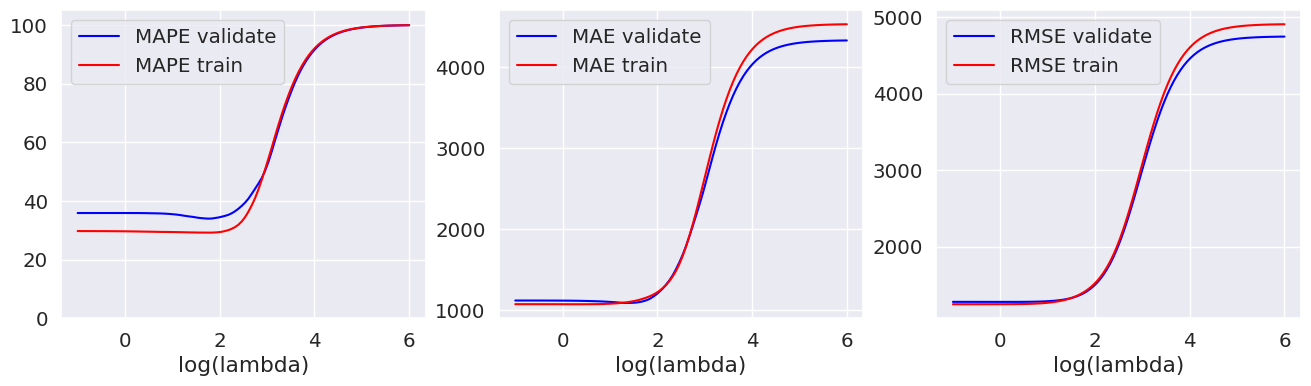

In [188]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# Plot for MAPE
axs[0].plot(np.log10(lambd_array), mape_validate, color='blue', label='MAPE validate')
axs[0].plot(np.log10(lambd_array), mape_train, color='red', label='MAPE train')
axs[0].set_xlabel('log(lambda)')
axs[0].set_ylim(0, 105)

# Plot for MAE
axs[1].plot(np.log10(lambd_array), mae_validate, color='blue', label='MAE validate')
axs[1].plot(np.log10(lambd_array), mae_train, color='red', label='MAE train')
axs[1].set_xlabel('log(lambda)')

# Plot for RMSE
axs[2].plot(np.log10(lambd_array), rmse_validate, color='blue', label='RMSE validate')
axs[2].plot(np.log10(lambd_array), rmse_train, color='red', label='RMSE train')
axs[2].set_xlabel('log(lambda)')

for i in range(3):
    axs[i].legend()
    axs[i].grid(True)

plt.show()

Явно видна зависимость метрик от lambda: около 10^2 (т.е. 100), все 3 метрики резко начинают увеличиваться и их бурный рост прекращается примерно при lambda = 10^4 (т.е. 1000). Видно, что оптимальное значение lambda стоит искать в промежутке от 0 до 10^3 = 1000.

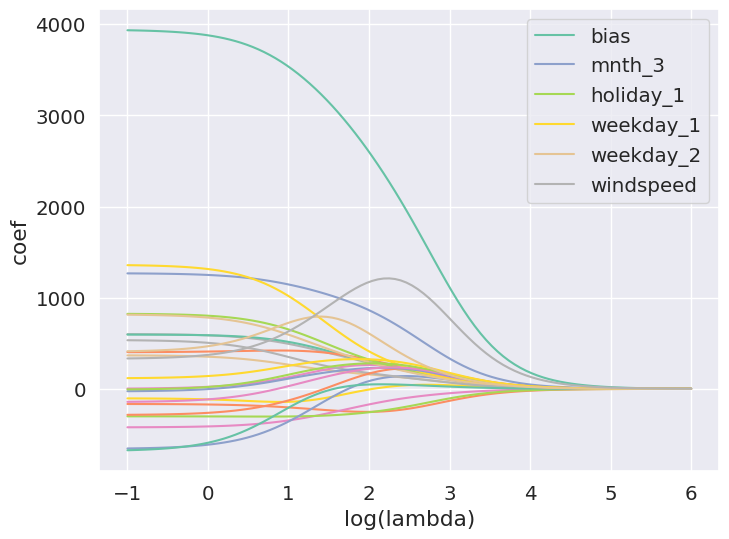

In [189]:
labels = ['bias'] + list(encoder.get_feature_names_out()) + real_features
plt.figure(figsize=(8, 6))
for i in range(len(model_coefficients)):   
    if np.max(model_coefficients[i])>800:
        plt.plot(np.log10(lambd_array), model_coefficients[i], label=labels[i])
    else:
        plt.plot(np.log10(lambd_array), model_coefficients[i])
plt.xlabel('log(lambda)')
plt.ylabel('coef')
plt.legend()
plt.grid(True)

plt.show()

Коэффициенты сходятся к 0 при увеличении lambda. Это происходит из-за слишком большого вклада свободного члена в градиент. Можно сделать вывод, что при чрезмерно больших lambda модель будет показывать плохие значения некоторых метрик, так как учитываться будет почти только один свободный член

Выберем оптимальное значение гиперпараметра и посчитайте ошибку на тестовой выборке.

In [230]:
k = 100
lambd_array = np.linspace(0.01, 250, k)

rmse_validate = np.zeros(k)
mae_validate = np.zeros(k)
mape_validate = np.zeros(k)

rmse_train = np.zeros(k)
mae_train = np.zeros(k)
mape_train = np.zeros(k)

validate_cat = encoder.transform(validate[categorial_features])
validate_real = scaler.transform(validate[real_features])
X_validate = np.hstack([validate_real, validate_cat])

ind = 0
for lambd in lambd_array:
    model = RidgeRegression(lambd, fit_intercept=True)
    model.fit(X_train, train[target_feature])
    
    validate_preds = model.predict(X_validate)
    np.put(mae_validate, ind, metrics.mean_absolute_error(validate[target_feature], validate_preds))
    np.put(rmse_validate, ind, metrics.mean_squared_error(validate[target_feature], validate_preds) ** 0.5)
    np.put(mape_validate, ind, mean_absolute_percentage_error(validate[target_feature], validate_preds))

    train_preds = model.predict(X_train)
    np.put(mae_train, ind, metrics.mean_absolute_error(train[target_feature], train_preds))
    np.put(rmse_train, ind, metrics.mean_squared_error(train[target_feature], train_preds) ** 0.5)
    np.put(mape_train, ind, mean_absolute_percentage_error(train[target_feature], train_preds))
    
    ind += 1

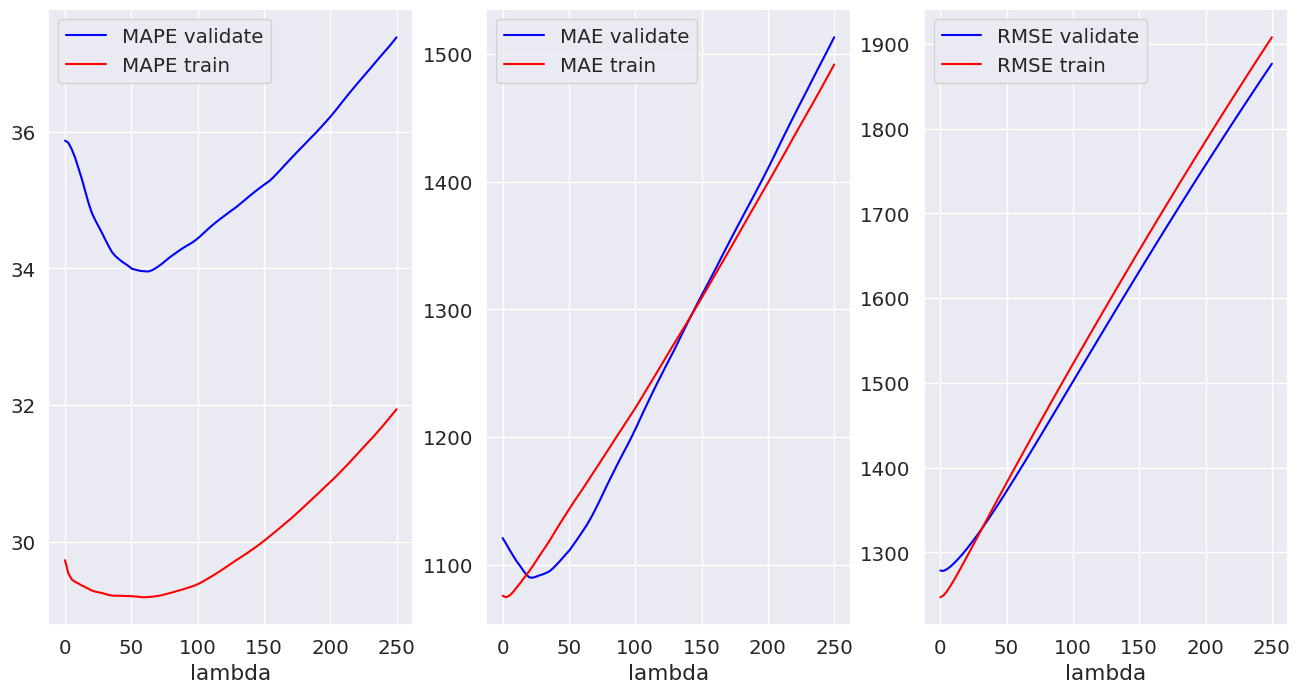

In [231]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot for MAPE
axs[0].plot(lambd_array, mape_validate, color='blue', label='MAPE validate')
axs[0].plot(lambd_array, mape_train, color='red', label='MAPE train')
axs[0].set_xlabel('lambda')

# Plot for MAE
axs[1].plot(lambd_array, mae_validate, color='blue', label='MAE validate')
axs[1].plot(lambd_array, mae_train, color='red', label='MAE train')
axs[1].set_xlabel('lambda')

# Plot for RMSE
axs[2].plot(lambd_array, rmse_validate, color='blue', label='RMSE validate')
axs[2].plot(lambd_array, rmse_train, color='red', label='RMSE train')
axs[2].set_xlabel('lambda')

for i in range(3):
    axs[i].legend()
    axs[i].grid(True)

plt.show()

In [232]:
min_mape_lambd = lambd_array[np.argmin(mape_validate)]
min_mae_lambd = lambd_array[np.argmin(mae_validate)]
min_rmse_lambd = lambd_array[np.argmin(rmse_validate)]

In [233]:
print(min_mape_lambd, min_mae_lambd, min_rmse_lambd)

63.13878787878788 22.736363636363638 2.535151515151515


Минимумы MAPE, MAE и RMSE при lambda равным 63.1, 22.7 и 2.5 соответственно. Таким образом, если мы хотим, чтобы модель показывала наилуший результат по одной из метрик, то возьмем значение lambda, соответствующее ей.

In [240]:
lambds = [min_mae_lambd, min_rmse_lambd, min_mape_lambd]

In [241]:
errs = []

for l in lambds:
    model = RidgeRegression(l, fit_intercept=True)
    model.fit(train, train[target_feature])

    test_preds = model.predict(test)
    mae = metrics.mean_absolute_error(test[target_feature], test_preds)
    rmse = metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5
    mape = mean_absolute_percentage_error(test[target_feature], test_preds)
    
    errs.append([mae, rmse, mape])

Ошибка на тестовой выборке для трёх значений lambda

In [242]:
e = pd.DataFrame(errs)
e.columns = 'MAE', 'RMSE', 'MAPE'
e.index = ['min MAE lambd', 'min RMSE lambd', 'min MAPE lambd']
e

,MAE,RMSE,MAPE
min MAE lambd,0.000027,0.000034,7.360503e-07
min RMSE lambd,0.000004,0.000005,1.045380e-07
min MAPE lambd,0.000068,0.000083,1.799667e-06


Ошибка на тренировочной части данных для этих значений lambda

In [243]:
errs = []

for l in lambds:
    model = RidgeRegression(l, fit_intercept=True)
    model.fit(train, train[target_feature])

    train_preds = model.predict(train)
    mae = metrics.mean_absolute_error(train[target_feature], train_preds)
    rmse = metrics.mean_squared_error(train[target_feature], train_preds) ** 0.5
    mape = mean_absolute_percentage_error(train[target_feature], train_preds)
    
    errs.append([mae, rmse, mape])
    
e = pd.DataFrame(errs)
e.columns = 'MAE', 'RMSE', 'MAPE'
e.index = ['min MAE lambd', 'min RMSE lambd', 'min MAPE lambd']
e

,MAE,RMSE,MAPE
min MAE lambd,0.000026,0.000031,7.584202e-07
min RMSE lambd,0.000004,0.000004,1.012560e-07
min MAPE lambd,0.000065,0.000078,1.874053e-06


Для каждой из метрик соответствующее значение lambda на тестовой выборке незначительно уступает значению на тренировочной части. Однако lambda соответствующая MAE показала себя на этой метрике хуже, чем lambda, соответствующая RMSE. Таким образом, можно заметить, что результаты метрик несильно отличаются в зависимости от lambda из данного набора, поэтому, если мы хотим выбрать одно оптимальное значение, можно взять среднее между ними

In [246]:
total_optimal_lambda = (min_mae_lambd + min_mape_lambd + min_rmse_lambd) / 3

In [254]:
model = RidgeRegression(total_optimal_lambda, fit_intercept=True)
model.fit(train, train[target_feature])

test_preds = model.predict(test)
mae = metrics.mean_absolute_error(test[target_feature], test_preds)
rmse = metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5
mape = mean_absolute_percentage_error(test[target_feature], test_preds)
    
    
e = pd.DataFrame([[mae, rmse, mape]])
e.columns = 'MAE', 'RMSE', 'MAPE'
e.index = ['optimal lambda']
e

,MAE,RMSE,MAPE
optimal lambda,0.000034,0.000042,9.199495e-07


#### Выводы


* Ridge-регрессия позволять избежать проблемы больших коэффициентов. На графике зависимости коэффициентов от lambda видно, что они сходятся к 0. Однако при этом чрезмерно большом lambda ухудшаются метрики, поэтому необходимо искать оптимальное значение

* Можно рассматривать оптимальное значение lambda для каждой метрики по-отдельности, но метрики при этих lambda отличаются между собой незначительно, поэтому при необходимости выбрать одно оптимальное значение lambda можно взять их среднее арифметическое

